In [2]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
from dotenv import dotenv_values

from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string

In [3]:

config = dotenv_values()

# define variables for the login
pg_user = config['POSTGRES_USER']  # align the key label with your .env file !
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']


url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'


In [4]:
engine = create_engine(url, echo=False)
my_schema = 'capstone_barstov_industries'

with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {my_schema};'))


In [5]:
with engine.begin() as conn: # Done with echo=False
    result = conn.execute(text(f'''
                               SELECT * FROM product_analysis; 
                                '''))
    data = result.all()

### Let's create a dataframe out of that
product_analysis = pd.DataFrame(data)#, columns=['...', '...', '...']) 
product_analysis

,article_id,product_type_no,product_type_name,product_group_name,colour_group_code,colour_group_name,index_code,index_name,section_name,garment_group_no,unique_customers,total_sales,average_price,month,week,units_sold,abc_category,avg_customer_age,postal_code
0,572797001,253,Vest top,Garment Upper body,9,Black,A,Ladieswear,Womens Casual,1005,9623,1.401441,0.010523,2020-08-01,2020-08-17,49,A,39.823633,f8e422ead9eb7b22f861bdc7ab44586cb8103c275e2337...
1,898931001,253,Vest top,Garment Upper body,9,Black,A,Ladieswear,Womens Casual,1005,480,1.636340,0.011504,2020-08-01,2020-08-17,51,A,37.151210,80355192cecd5f9e9bc8994f4aded657eb0cc373e8e1d7...
2,884754001,274,Shorts,Garment Lower body,93,Dark Green,F,Menswear,Men Underwear,1002,187,0.389559,0.023839,2020-08-01,2020-08-10,16,A,35.058511,403b00eebb203284edddcee9da2c13d6a819c35f609c31...
3,893429001,67,Belt,Accessories,9,Black,C,Ladies Accessories,Womens Big accessories,1019,526,0.065203,0.008249,2020-08-01,2020-08-10,9,B,30.569316,4f88f48fd1345f6ae3a634caadee2d9355d50a34f3ec53...
4,856840001,265,Dress,Garment Full body,12,Light Beige,A,Ladieswear,Womens Everyday Collection,1005,1707,5.455941,0.016212,2020-08-01,2020-08-17,102,A,49.056150,65e83d1376cd2882461012272f95450b96795dfbc3243b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104505,941138001,255,T-shirt,Garment Upper body,9,Black,I,Children Sizes 134-170,Girls Underwear & Basics,1002,1,0.016932,0.016932,2020-09-01,2020-09-14,1,C,48.000000,e3fc02798f64670d30a3a0d3bfa0169e58261d6e0d92cf...
104506,874848006,255,T-shirt,Garment Upper body,7,Grey,H,Children Sizes 92-140,Kids Boy,1005,1,0.016932,0.016932,2020-07-01,2020-07-20,1,C,35.000000,63d6d7a3e63979990b8aad4ebb55fa1b4abe1f522a3109...
104507,806293001,69,Cap/peaked,Accessories,51,Light Pink,J,"Children Accessories, Swimwear",Kids Outerwear,1019,1,0.008458,0.008458,2020-08-01,2020-08-03,1,C,35.000000,86af1af82002c1fbd2da8769c2bea30e5a09709dcbf445...
104508,620216073,273,Leggings/Tights,Garment Lower body,73,Dark Blue,H,Children Sizes 92-140,Girls Underwear & Basics,1002,1,0.010153,0.010153,2020-07-01,2020-07-20,1,C,28.000000,875d6ab894415ba0139c42ba08d4c2667f1a851d7c578a...


In [6]:
from sklearn.preprocessing import StandardScaler
selected_data = product_analysis[['total_sales', 'unique_customers', 'units_sold', 'avg_customer_age']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)


In [7]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)


In [8]:
import numpy as np
unique, counts = np.unique(dbscan_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)


Cluster distribution: {np.int64(-1): np.int64(2100), np.int64(0): np.int64(102250), np.int64(1): np.int64(5), np.int64(2): np.int64(18), np.int64(3): np.int64(5), np.int64(4): np.int64(8), np.int64(5): np.int64(6), np.int64(6): np.int64(4), np.int64(7): np.int64(5), np.int64(8): np.int64(8), np.int64(9): np.int64(5), np.int64(10): np.int64(8), np.int64(11): np.int64(5), np.int64(12): np.int64(5), np.int64(13): np.int64(5), np.int64(14): np.int64(6), np.int64(15): np.int64(6), np.int64(16): np.int64(8), np.int64(17): np.int64(6), np.int64(18): np.int64(5), np.int64(19): np.int64(7), np.int64(20): np.int64(5), np.int64(21): np.int64(5), np.int64(22): np.int64(5), np.int64(23): np.int64(3), np.int64(24): np.int64(3), np.int64(25): np.int64(5), np.int64(26): np.int64(4), np.int64(27): np.int64(5)}


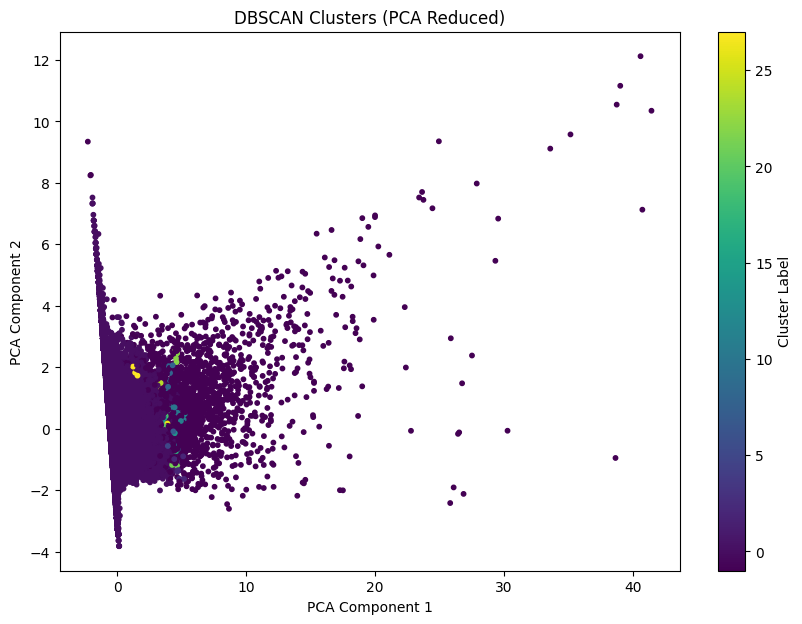

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Plot clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("DBSCAN Clusters (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()


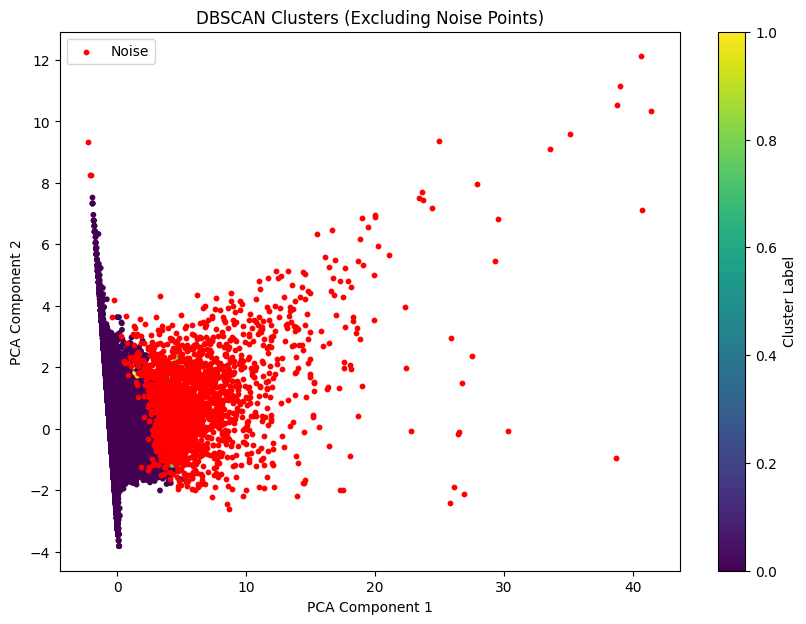

In [10]:
# Mask for core points (exclude noise)
core_samples_mask = dbscan_labels != -1

plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[core_samples_mask, 0], reduced_data[core_samples_mask, 1],
            c=dbscan_labels[core_samples_mask], cmap='viridis', s=10)
plt.scatter(reduced_data[~core_samples_mask, 0], reduced_data[~core_samples_mask, 1],
            color='red', s=10, label='Noise')
plt.title("DBSCAN Clusters (Excluding Noise Points)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()


In [11]:

dbscan = DBSCAN(eps=0.6, min_samples=5)
dbscan_labels2 = dbscan.fit_predict(scaled_data)

KeyboardInterrupt: 

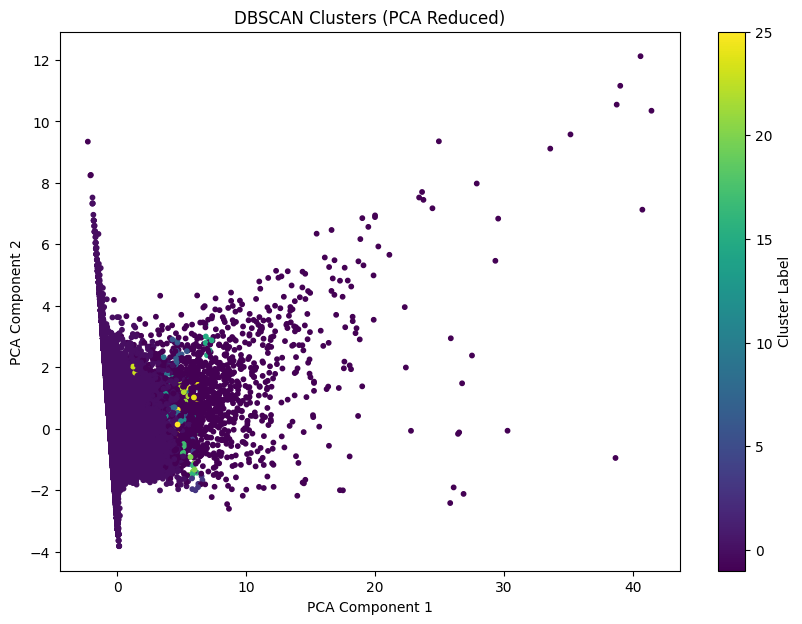

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Plot clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels2, cmap='viridis', s=10)
plt.title("DBSCAN Clusters (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()


In [7]:
from sklearn.decomposition import PCA

# Reduce to 3 components
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(scaled_data)


In [8]:
from sklearn.cluster import DBSCAN

# Run DBSCAN with adjusted eps on reduced data
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(reduced_data)


: 

In [8]:
import numpy as np

# Sample indices and extract those rows
sample_indices = np.random.choice(scaled_data.shape[0], 20000, replace=False)
sample_data = scaled_data[sample_indices]


In [11]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(sample_data)

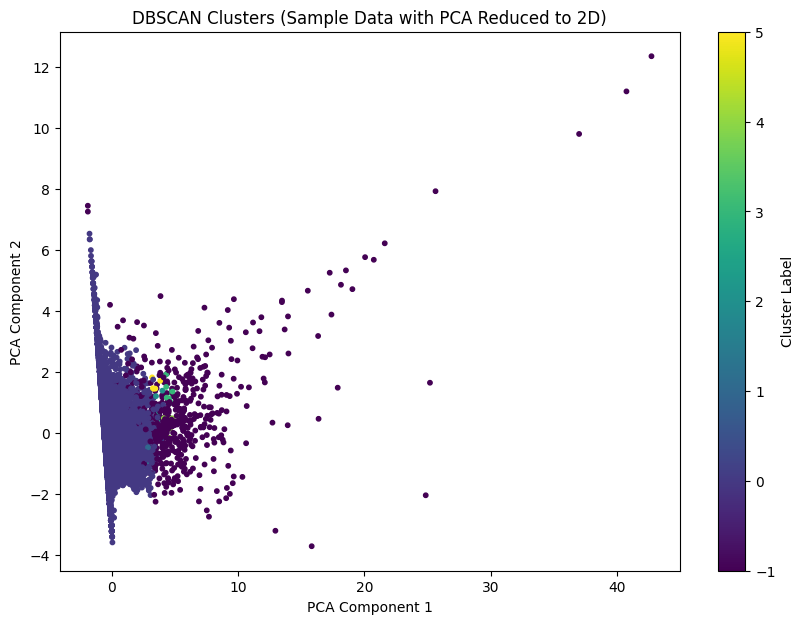

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Further reduce the sampled data to 2 dimensions for visualization
pca_2d = PCA(n_components=2)
sample_data_2d = pca_2d.fit_transform(sample_data)

# Visualize the clusters
plt.figure(figsize=(10, 7))
plt.scatter(sample_data_2d[:, 0], sample_data_2d[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("DBSCAN Clusters (Sample Data with PCA Reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()


In [13]:
pip install hdbscan


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 11.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.39-cp312-cp312-macosx_11_0_arm64.whl size=705021 sha256=e9ef6d1c0d12bcb3140e6f84c42396d3013611e375a6e8b90b3c91c355c4b2ac
  Stored in directory: /Users/emmalebars/Library/Caches/pip/wheels/d6/95/08/1b7af0aaa49099499fa2f99cb7a512d962f84958e00fe4f580
Successfully built hdbscan
Note: you may need to restart the kernel to use updated packages.


In [14]:
import hdbscan

# Initialize HDBSCAN with custom parameters
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=30)
hdbscan_labels = hdbscan_clusterer.fit_predict(scaled_data)


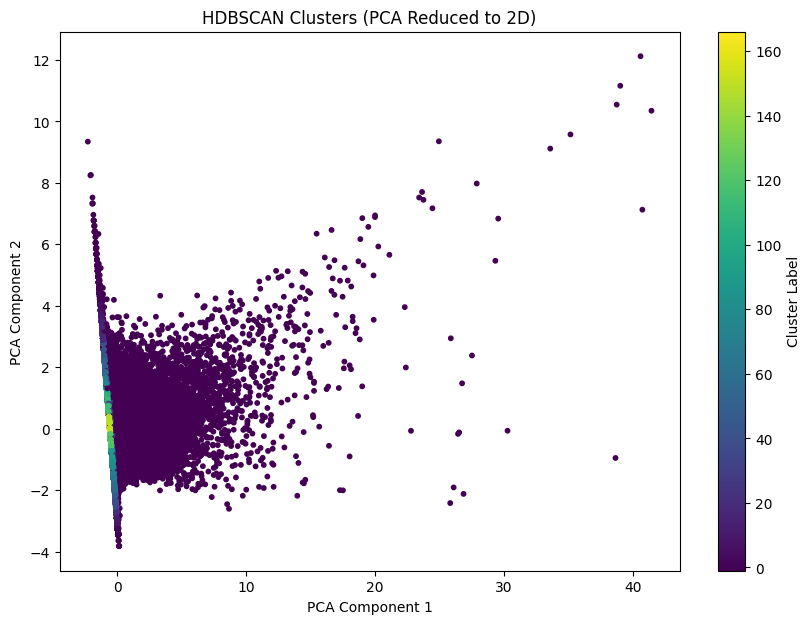

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_data_2d = pca.fit_transform(scaled_data)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], c=hdbscan_labels, cmap='viridis', s=10)
plt.title("HDBSCAN Clusters (PCA Reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()


Silhouette Score: -0.4831003846366091


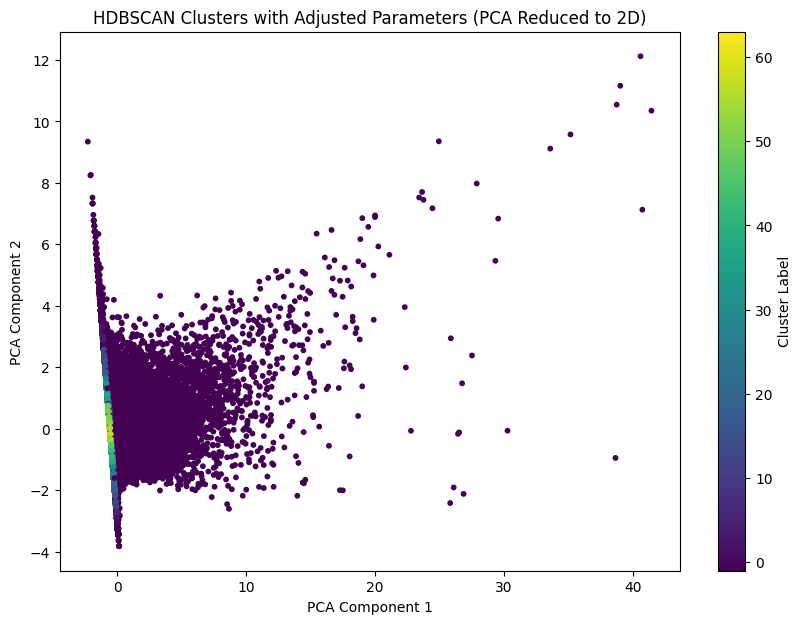

In [16]:
import hdbscan
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set up HDBSCAN with adjusted parameters
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100)
hdbscan_labels = hdbscan_clusterer.fit_predict(scaled_data)

# Calculate Silhouette Score (only if there are more than 1 cluster labels)
if len(set(hdbscan_labels)) > 1:
    silhouette_avg = silhouette_score(scaled_data, hdbscan_labels)
    print("Silhouette Score:", silhouette_avg)
else:
    print("Silhouette Score could not be computed due to a single cluster.")

# Visualization with PCA for 2D
pca = PCA(n_components=2)
reduced_data_2d = pca.fit_transform(scaled_data)

# Plot clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], c=hdbscan_labels, cmap='viridis', s=10)
plt.title("HDBSCAN Clusters with Adjusted Parameters (PCA Reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()


In [17]:
import numpy as np

unique, counts = np.unique(hdbscan_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)

Cluster distribution: {np.int64(-1): np.int64(72518), np.int64(0): np.int64(119), np.int64(1): np.int64(110), np.int64(2): np.int64(140), np.int64(3): np.int64(168), np.int64(4): np.int64(144), np.int64(5): np.int64(127), np.int64(6): np.int64(275), np.int64(7): np.int64(9459), np.int64(8): np.int64(1272), np.int64(9): np.int64(3567), np.int64(10): np.int64(149), np.int64(11): np.int64(208), np.int64(12): np.int64(110), np.int64(13): np.int64(167), np.int64(14): np.int64(201), np.int64(15): np.int64(276), np.int64(16): np.int64(148), np.int64(17): np.int64(260), np.int64(18): np.int64(242), np.int64(19): np.int64(124), np.int64(20): np.int64(226), np.int64(21): np.int64(197), np.int64(22): np.int64(146), np.int64(23): np.int64(207), np.int64(24): np.int64(265), np.int64(25): np.int64(162), np.int64(26): np.int64(297), np.int64(27): np.int64(272), np.int64(28): np.int64(325), np.int64(29): np.int64(306), np.int64(30): np.int64(191), np.int64(31): np.int64(170), np.int64(32): np.int64(21

In [18]:
import pandas as pd

# Assuming `scaled_data` was converted back to a DataFrame with original columns
# Add cluster labels to the DataFrame
data_with_clusters = pd.DataFrame(scaled_data, columns=['total_sales', 'unique_customers', 'units_sold', 'average_price'])
data_with_clusters['cluster'] = hdbscan_labels

# Calculate average characteristics for each cluster
cluster_summary = data_with_clusters.groupby('cluster').mean()
print(cluster_summary)

         total_sales  unique_customers  units_sold  average_price
cluster                                                          
-1          0.122257          0.168853    0.119738      -0.018095
 0         -0.281857         -0.407283   -0.299421       3.804727
 1         -0.290242         -0.407700   -0.300097      -3.128051
 2         -0.291438         -0.407339   -0.299642      -2.935983
 3         -0.277394         -0.407198   -0.299589       3.410002
...              ...               ...         ...            ...
 59        -0.290136         -0.398261   -0.300893      -0.201605
 60        -0.290096         -0.395432   -0.300893      -0.128430
 61        -0.292199         -0.395544   -0.300893       0.060343
 62        -0.290610         -0.397353   -0.300893       0.025467
 63        -0.290370         -0.403818   -0.300893       0.001438

[65 rows x 4 columns]


### Product types / colour combination clustering ###

In [20]:
# Aggregate data by product type and color group to summarize demand
product_data = product_analysis.groupby(['product_type_no', 'colour_group_code', 'garment_group_no']).agg({
    'units_sold': 'sum'  # Aggregated demand
}).reset_index()


In [21]:
from sklearn.preprocessing import StandardScaler

# Select features for scaling
features = product_data[['units_sold', 'product_type_no', 'colour_group_code', 'garment_group_no']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)


In [22]:
import hdbscan

# Initialize HDBSCAN with chosen parameters
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10)
product_clusters = hdbscan_clusterer.fit_predict(scaled_data)

# Add cluster labels back to the data
product_data['cluster'] = product_clusters


In [23]:
import numpy as np

# Display cluster distribution
unique, counts = np.unique(product_clusters, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)


Cluster distribution: {np.int64(-1): np.int64(1626), np.int64(0): np.int64(17), np.int64(1): np.int64(64), np.int64(2): np.int64(76), np.int64(3): np.int64(12), np.int64(4): np.int64(10), np.int64(5): np.int64(10), np.int64(6): np.int64(14), np.int64(7): np.int64(61), np.int64(8): np.int64(17), np.int64(9): np.int64(12), np.int64(10): np.int64(10), np.int64(11): np.int64(33), np.int64(12): np.int64(31), np.int64(13): np.int64(18), np.int64(14): np.int64(10), np.int64(15): np.int64(15), np.int64(16): np.int64(10), np.int64(17): np.int64(53), np.int64(18): np.int64(20), np.int64(19): np.int64(15), np.int64(20): np.int64(49), np.int64(21): np.int64(11), np.int64(22): np.int64(35), np.int64(23): np.int64(65), np.int64(24): np.int64(19), np.int64(25): np.int64(29), np.int64(26): np.int64(63), np.int64(27): np.int64(26), np.int64(28): np.int64(51), np.int64(29): np.int64(28), np.int64(30): np.int64(54), np.int64(31): np.int64(80), np.int64(32): np.int64(35), np.int64(33): np.int64(148), np.i

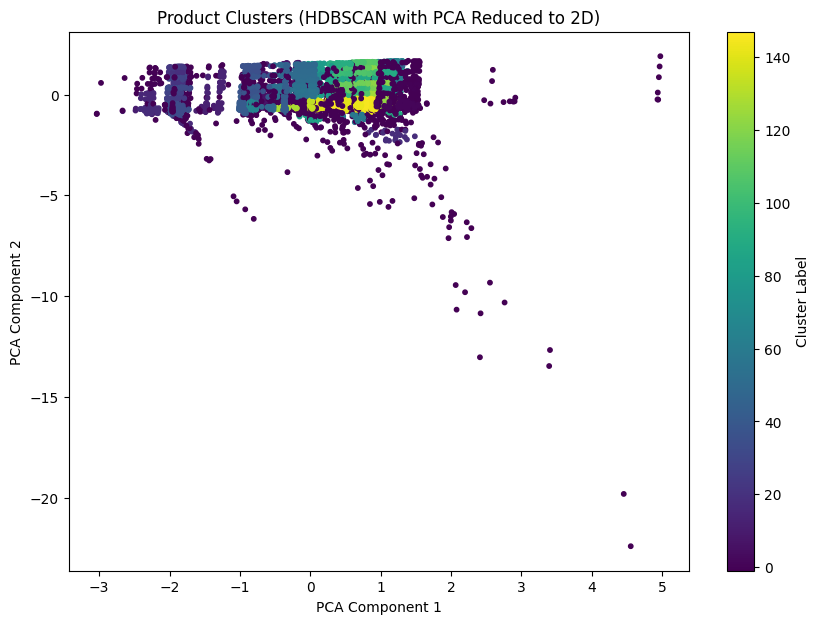

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Plot clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=product_clusters, cmap='viridis', s=10)
plt.title("Product Clusters (HDBSCAN with PCA Reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()


In [25]:
# Summarize average demand and characteristics by cluster
cluster_summary = product_data.groupby('cluster').mean()
print(cluster_summary)

         product_type_no  colour_group_code  garment_group_no  units_sold
cluster                                                                  
-1            237.676507          37.457565       1010.762608  406.445264
 0            508.470588          50.294118       1019.000000   19.000000
 1            499.781250          10.312500       1019.046875   15.265625
 2             76.052632          12.131579       1001.000000    5.671053
 3             76.083333          11.000000       1003.000000    4.500000
...                  ...                ...               ...         ...
 143          262.241379           9.206897       1008.000000   13.137931
 144          263.757576          12.611111       1005.000000   36.883838
 145          262.742138          13.232704       1006.000000   10.452830
 146          265.000000          11.172414       1011.000000    7.344828
 147          261.708861          12.417722       1010.000000   22.620253

[149 rows x 4 columns]


In [26]:
# Calculate the size of each cluster
cluster_sizes = product_data['cluster'].value_counts().sort_values()
print("Cluster sizes (number of points in each cluster):")
print(cluster_sizes)


Cluster sizes (number of points in each cluster):
cluster
 14       10
 5        10
 10       10
 16       10
 125      10
        ... 
 145     159
 144     198
 131     216
 34      265
-1      1626
Name: count, Length: 149, dtype: int64


In [30]:
# Identify the smallest clusters (e.g., clusters with fewer than 20 points)
small_clusters = cluster_sizes[cluster_sizes < 11].index.tolist()

# Identify the largest clusters (e.g., clusters with more than 100 points)
large_clusters = cluster_sizes[cluster_sizes > 100].index.tolist()

print("Small clusters:", small_clusters)
print("Large clusters:", large_clusters)


Small clusters: [14, 5, 10, 16, 125, 97, 90, 4, 110]
Large clusters: [130, 33, 145, 144, 131, 34, -1]


In [32]:
# Example: Inspect one small cluster and one large cluster
for cluster_id in [small_clusters[8], large_clusters[5]]:  # Adjust the indices to inspect different clusters
    print(f"\nSummary for Cluster {cluster_id}")
    cluster_data = product_data[product_data['cluster'] == cluster_id]
    print(cluster_data.describe())  # Summary statistics for the cluster



Summary for Cluster 110
       product_type_no  colour_group_code  garment_group_no  units_sold  \
count        10.000000           10.00000              10.0   10.000000   
mean        258.800000           41.30000            1010.0   16.800000   
std           5.159673            1.05935               0.0   21.049149   
min         253.000000           40.00000            1010.0    1.000000   
25%         254.000000           41.00000            1010.0    4.750000   
50%         258.500000           41.00000            1010.0   11.500000   
75%         264.250000           41.75000            1010.0   17.000000   
max         265.000000           43.00000            1010.0   72.000000   

       cluster  
count     10.0  
mean     110.0  
std        0.0  
min      110.0  
25%      110.0  
50%      110.0  
75%      110.0  
max      110.0  

Summary for Cluster 34
       product_type_no  colour_group_code  garment_group_no  units_sold  \
count       265.000000         265.000000      